In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import geopandas as gpd
import numpy as np

## Upload data

In [2]:
# Gender violence citizen reports in Monterrey, Mexico from 2017 to september 2022. This database has been downloaded from the Municipality of Monterrey's open
# data portal at datos.monterrey.gob.mx. The "fecha" column has been cleaned previously to follow a parsable format.

violencia = pd.read_csv("data/violencia_genero_mty2.csv")

## Clean data

In [3]:
#Replace error in value on column "estado".

violencia = violencia.replace(to_replace=['NUEVO LEON'], value='NL')

In [4]:
#Replace null values on column "estado".

violencia['estado'].fillna('NL', inplace = True)

In [5]:
#Replace null values on column "colonia".

violencia['colonia'].fillna('Sin nombre de colonia', inplace = True)

In [6]:
# Create new datetime column combining "fecha" and "hora_recepcion".

violencia["fecha_recepcion"] = violencia["fecha"] + " " + violencia["hora_recepcion"]

violencia["fecha_recepcion"] = pd.to_datetime(violencia["fecha_recepcion"], dayfirst = True)

del violencia["fecha"]
del violencia["hora_recepcion"]

In [7]:
# Drop unnecessary columns.

del violencia["municipio"]
del violencia["estado"]

In [8]:
# Clarify name values from "corporacion".

violencia["corporacion"] = violencia["corporacion"].replace("FZACIVIL", "Fuerza Civil")
violencia["corporacion"] = violencia["corporacion"].replace("PMON", "Policía de Monterrey")
violencia["corporacion"] = violencia["corporacion"].replace("GCIVIL", "Guardia Civil")
violencia["corporacion"] = violencia["corporacion"].replace("SVTM", "Secretaría de Vialidad y Tránsito")

In [9]:
# Clean values in "descripcion_cierre" y "via_recepcion".

violencia = violencia.replace({"descripcion_cierre" : {"Cierre De Fuga": "Cierre de fuga", "Remitido Al M.p.": "Remitido al Ministerio Público",
                                           "Fuera De Subzona": "Fuera de subzona", "Fuera De Entidad Federativa": "Fuera de Entidad Federativa"}})

violencia = violencia.replace({"via_recepcion" : {"Telefono": "Teléfono", "Sala crisis": "Sala de crisis", "App": "App 911",
                                                   "App 9-1-1": "App 911", "Whats App": "WhatsApp", "Cic": "CIC"}})

## Visualizations

#### 1. Number of reports by year

In [37]:
# Add new "year" column.

violencia["ano"] = violencia["fecha_recepcion"].dt.year

# Create dataframe from value counts on "year".

violencia_ano = pd.DataFrame(violencia["ano"].value_counts())
violencia_ano = violencia_ano.reset_index()
violencia_ano.columns = ['Año', 'Reportes']

# Graph

violencia_ano = px.bar(violencia_ano, x="Año", y="Reportes")
violencia_ano.update_layout(yaxis={'categoryorder':'total ascending'})
violencia_ano.update_layout(margin=dict(l=0, r=0, b=0, t=0))
violencia_ano.update_yaxes(visible=False)
violencia_ano.update_xaxes(title=None)
violencia_ano.update_layout(modebar=dict(remove=["zoom", "toimage", "pan", "select", "lasso", "zoomin", "zoomout", "autoscale", "reset",
                                                "resetscale"]))

violencia_ano.write_html('reportes_ano.html')

#### 2. ¿On which month where most reports done?

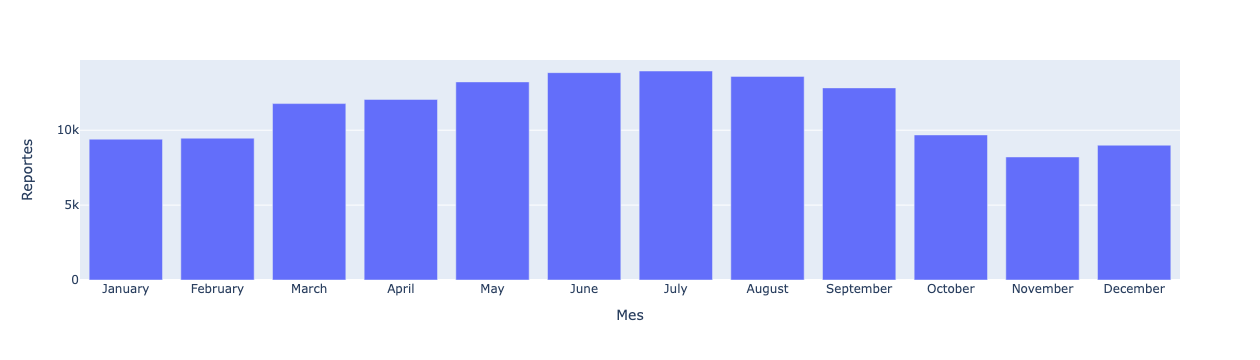

In [58]:
# Add new "month" column.

violencia["mes"] = violencia["fecha_recepcion"].dt.month_name()

# Create dataframe from value counts on "month".

violencia_mes = pd.DataFrame(violencia["mes"].value_counts())
violencia_mes = violencia_mes.reset_index()
violencia_mes.columns = ['Mes', 'Reportes']

# Sort by name of month.

meses = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
violencia_mes['Mes'] = pd.Categorical(violencia_mes['Mes'], categories=meses, ordered=True)
violencia_mes.sort_values(by='Mes',inplace=True)

# Graph

violencia_mes = px.bar(violencia_mes, x="Mes", y="Reportes")
violencia_mes.update_layout(yaxis={'categoryorder':'total ascending'})
#violencia_mes.write_html('first_figure.html', auto_open=True)

#### 3. Time of day with greater number of reports

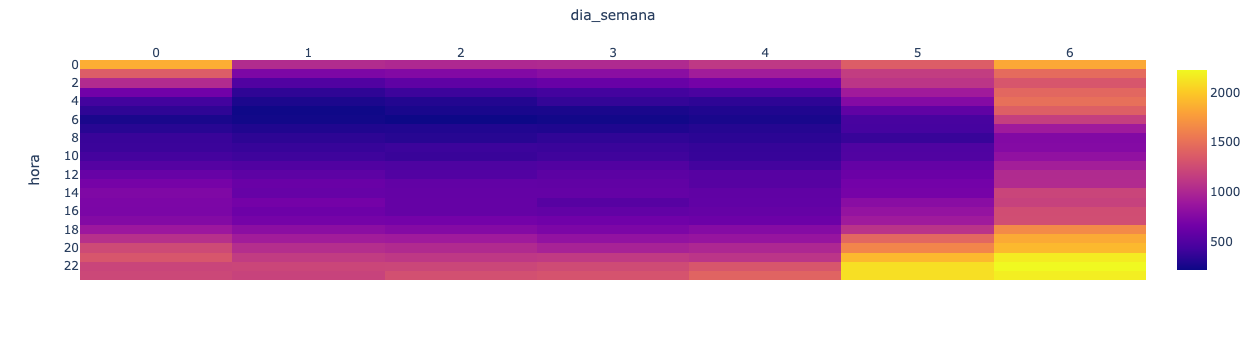

In [59]:
# Add new "hour" and "day of week" column.

violencia["hora"] = violencia["fecha_recepcion"].dt.hour
violencia["dia_semana"] = violencia["fecha_recepcion"].dt.dayofweek

# Create pivot table. 

violencia["hora"] = violencia["hora"].apply(str)
violencia_diasemana = violencia.pivot_table(index = "hora", columns = "dia_semana", values = "numero_reporte", aggfunc = "count")
violencia_diasemana = violencia_diasemana.reset_index()

# Sort by hour of the day.

horas = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23"]
violencia_diasemana['hora'] = pd.Categorical(violencia_diasemana['hora'], categories=horas, ordered=True)
violencia_diasemana.sort_values(by='hora',inplace=True)

violencia_diasemana = violencia_diasemana.set_index("hora")

# Graph.

fig = px.imshow(violencia_diasemana)
fig.update_xaxes(side="top")
#fig.write_html('first_figure.html', auto_open=True)

#### 4. Type of violence reported

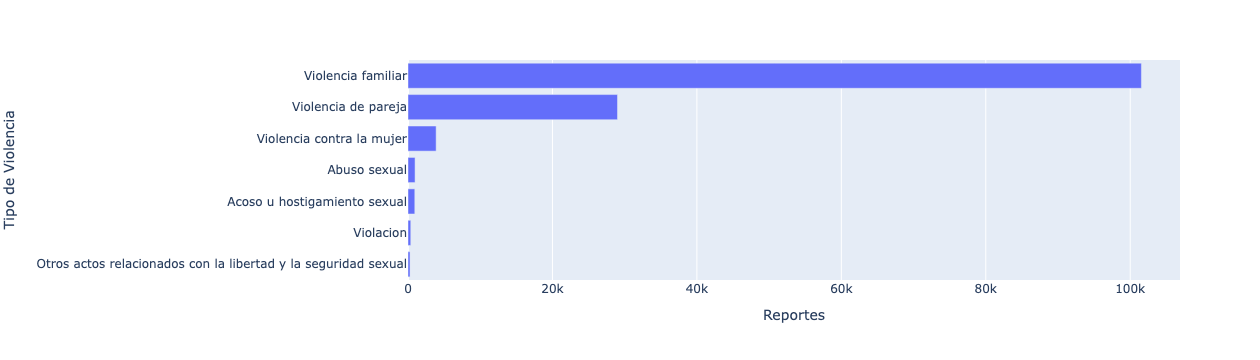

In [60]:
# Create dataframe from value counts on "descripcion_tipo".

violencia_tipo = pd.DataFrame(violencia["descripcion_tipo"].value_counts())
violencia_tipo = violencia_tipo.reset_index()
violencia_tipo.columns = ['Tipo de Violencia', 'Reportes']

# Graph.

violencia_tipo = px.bar(violencia_tipo, x='Reportes', y='Tipo de Violencia', orientation = "h")
violencia_tipo.update_layout(yaxis={'categoryorder':'total ascending'})
#violencia_tipo.write_html('first_figure.html', auto_open=True)

#### 5. ¿Through which media was the report done?

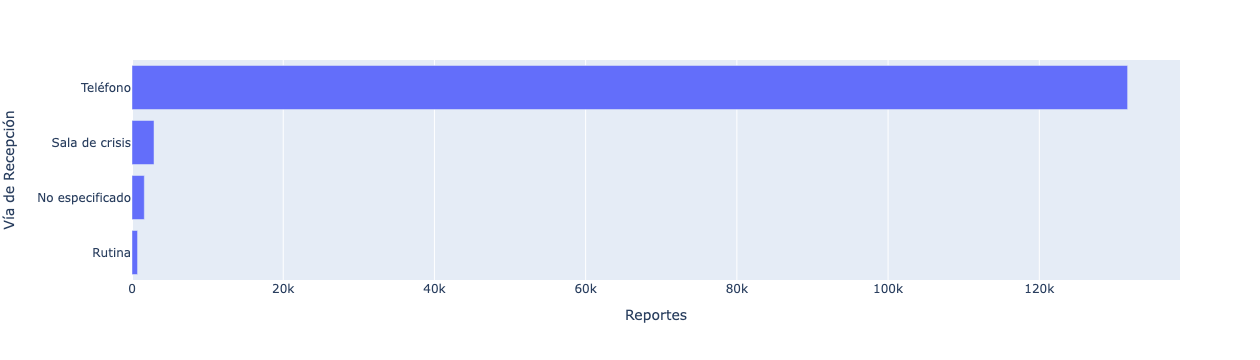

In [61]:
# Create dataframe from value counts on "via_recepcion". 

violencia_recepcion = pd.DataFrame(violencia["via_recepcion"].value_counts())

# Filter to top 4 most relevant results.

violencia_recepcion = violencia_recepcion[0:4]
violencia_recepcion = violencia_recepcion.reset_index()
violencia_recepcion.columns = ['Vía de Recepción', 'Reportes']

# Graph

violencia_recepcion = px.bar(violencia_recepcion, x='Reportes', y='Vía de Recepción', orientation = "h")
violencia_recepcion.update_layout(yaxis={'categoryorder':'total ascending'})
#violencia_recepcion.write_html('first_figure.html', auto_open=True)

#### 6. ¿Which corporation attended the report?

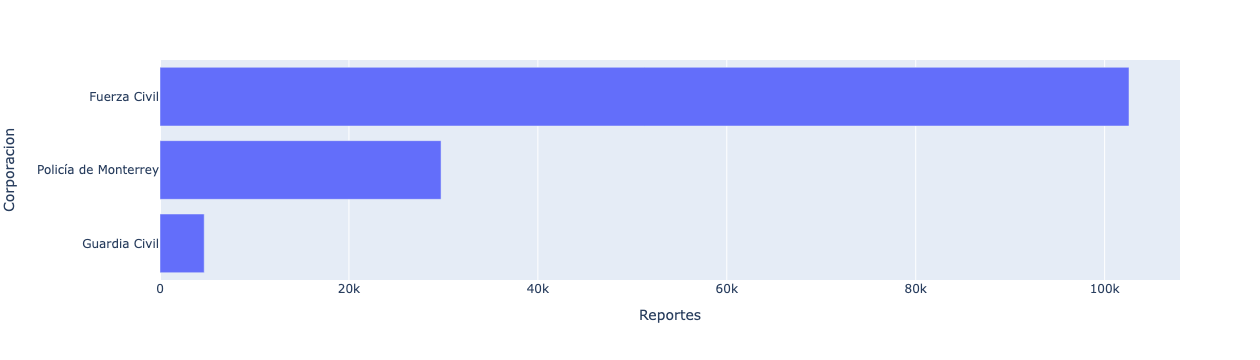

In [62]:
# Create dataframe from value counts on "corporacion".

violencia_corporacion = pd.DataFrame(violencia["corporacion"].value_counts())

# Remove Secretaría de Vialidad y Transito due to the small number of reports received.

violencia_corporacion = violencia_corporacion[0:3]
violencia_corporacion = violencia_corporacion.reset_index()
violencia_corporacion.columns = ['Corporacion', 'Reportes']

# Graph.

violencia_corporacion = px.bar(violencia_corporacion, x='Reportes', y='Corporacion', orientation = "h")
violencia_corporacion.update_layout(yaxis={'categoryorder':'total ascending'})
#violencia_corporacion.write_html('first_figure.html', auto_open=True)

#### 7. ¿How was the report classified?

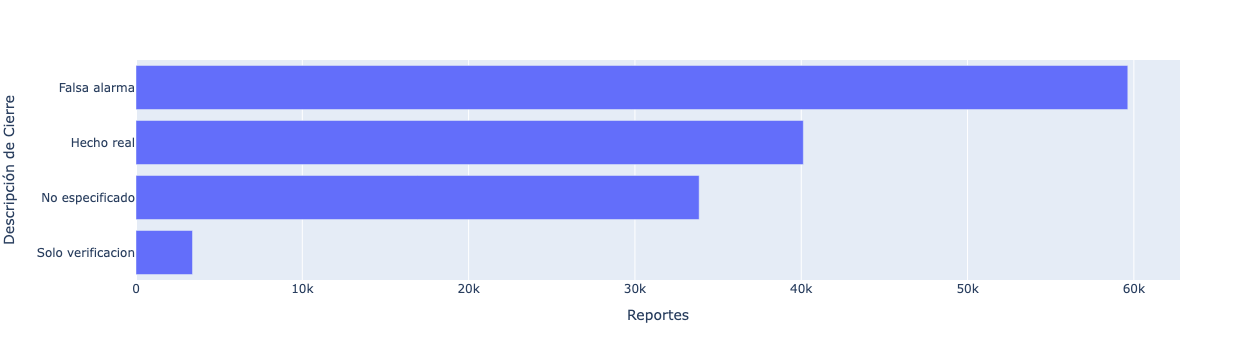

In [63]:
# Create dataframe from value counts on "descripcion_cierre".

violencia_cierre = pd.DataFrame(violencia["descripcion_cierre"].value_counts())

# Filter to top 4 most relevant results.

violencia_cierre = violencia_cierre[0:4]
violencia_cierre = violencia_cierre.reset_index()
violencia_cierre.columns = ['Descripción de Cierre', 'Reportes']

# Graph

violencia_cierre = px.bar(violencia_cierre, x='Reportes', y='Descripción de Cierre', orientation = "h")
violencia_cierre.update_layout(yaxis={'categoryorder':'total ascending'})
#violencia_cierre.write_html('first_figure.html', auto_open=True)

#### 8. Top 10 neighborhoods by number of reports

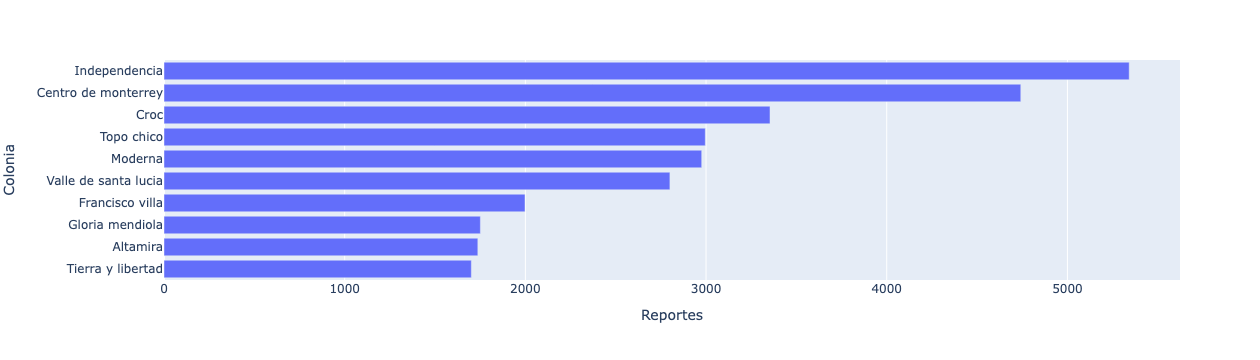

In [64]:
# Create dataframe from value counts on "colonia".

violencia_colonia = pd.DataFrame(violencia["colonia"].value_counts())
violencia_colonia = violencia_colonia[0:10]
violencia_colonia = violencia_colonia.reset_index()
violencia_colonia.columns = ['Colonia', 'Reportes']

# Graph

violencia_colonia = px.bar(violencia_colonia, x='Reportes', y='Colonia', orientation = "h")
violencia_colonia.update_layout(yaxis={'categoryorder':'total ascending'})
#violencia_colonia.write_html('first_figure.html', auto_open=True)

#### 9. Map

In [70]:
# Delete reports not located in the Municipality of Monterrey with QGIS.

#violencia.to_csv("data/violencia_genero_mty3.csv")

# Upload reports located only in Monterrey.

violencia_map = pd.read_csv("data/violencia_genero_mty4.csv")
del violencia_map["field_1"]

# Map.

px.set_mapbox_access_token(open(".mapbox_token").read())
fig = px.density_mapbox(violencia, lat="latitud", lon="longitud", zoom=11, radius=2)
#fig.write_html('first_figure.html', auto_open=True)